In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from joblib import dump
import ast  # para converter string em lista de tuplas
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


In [ ]:
df_bruno = pd.read_csv("../scrub/tabelas_pessoa_pos_tratamento/bruno.csv")
df_erik = pd.read_csv("../scrub/tabelas_pessoa_pos_tratamento/erik.csv")
df_felipe = pd.read_csv("../scrub/tabelas_pessoa_pos_tratamento/felipe.csv")
df_guilherme = pd.read_csv("../scrub/tabelas_pessoa_pos_tratamento/guilherme.csv")
df_jao = pd.read_csv("../scrub/tabelas_pessoa_pos_tratamento/jao.csv")
df_jose = pd.read_csv("../scrub/tabelas_pessoa_pos_tratamento/jose.csv")
df_lo = pd.read_csv("../scrub/tabelas_pessoa_pos_tratamento/lo.csv")

datasets = {
    "Bruno": df_bruno,
    "Erik": df_erik,
    "Felipe": df_felipe,
    "Guilherme": df_guilherme,
    "Jao": df_jao,
    "Jose": df_jose,
    "Lo": df_lo
}

print("--- Análise da Distribuição de Amostras por Voluntário ---")

    # Itera sobre cada dataframe para mostrar as informações
for nome, df in datasets.items():
    print(f"\nAnalisando dados de: {nome}")
    
    # 1. Mostra o tamanho total do dataframe
    total_amostras = len(df)
    print(f"Total de amostras: {total_amostras}")
    
    # 2. Mostra a contagem de piscadas e não piscadas
    # O .value_counts() faz a contagem de cada valor único na coluna 'piscando'
    contagem_piscadas = df['piscando'].value_counts()
    
    # Extrai os valores (usando .get(key, 0) para evitar erro se uma classe não existir)
    nao_piscadas = contagem_piscadas.get(False, 0)
    piscadas = contagem_piscadas.get(True, 0)
    
    print(f"  - Não Piscadas (False): {nao_piscadas}")
    print(f"  - Piscadas (True):     {piscadas}")

In [4]:
# Lista de dataframes
dfs = [
    df_bruno, df_erik, df_felipe, df_guilherme, df_jao, df_jose, df_lo
]

nomes = [
    "bruno", "erik", "felipe", "guilherme", "jao", "jose", "lo"
]

# SEED PARA NÃO TER QUE FICAR MUDANDO FIGURAS
SEED = 42

models = [
    DecisionTreeClassifier(random_state=SEED),
    RandomForestClassifier(random_state=SEED),
    LogisticRegression(max_iter=1000, random_state=SEED),
    KNeighborsClassifier()
]


# Normaliza coluna "piscando" para 0 e 1
for i in dfs:
    i["piscando"] = i["piscando"].map({False: 0, True: 1})


In [40]:

pontos_cols = ["pontos_olhos 1", "pontos_olhos 2", "pontos_olhos 3", "pontos_olhos 4", "pontos_olhos 5"]

def safe_eval(val):
    if isinstance(val, str):
        try:
            return ast.literal_eval(val)
        except Exception:
            return []
    elif isinstance(val, (list, tuple)):
        return val
    else:
        return []

for df in dfs:
    for col in pontos_cols:
        df[col] = df[col].apply(safe_eval)
        df[[f"{col}_x{j}" for j in range(19)]] = pd.DataFrame(
            df[col].apply(lambda pts: [p[0] for p in pts[:19]] + [None]*(19-len(pts))).tolist()
        )
        df[[f"{col}_y{j}" for j in range(19)]] = pd.DataFrame(
            df[col].apply(lambda pts: [p[1] for p in pts[:19]] + [None]*(19-len(pts))).tolist()
        )

/tmp/ipykernel_7114/1566512039.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f"{col}_x{j}" for j in range(19)]] = pd.DataFrame(
/tmp/ipykernel_7114/1566512039.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f"{col}_x{j}" for j in range(19)]] = pd.DataFrame(
/tmp/ipykernel_7114/1566512039.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

{'Acurácia': np.float64(0.998), 'Precisão': np.float64(0.996), 'Revocação': np.float64(0.998), 'F1-Score': np.float64(0.997)}
{'Acurácia': np.float64(0.998), 'Precisão': np.float64(0.997), 'Revocação': np.float64(0.999), 'F1-Score': np.float64(0.998)}
{'Acurácia': np.float64(0.942), 'Precisão': np.float64(0.944), 'Revocação': np.float64(0.902), 'F1-Score': np.float64(0.922)}
{'Acurácia': np.float64(0.986), 'Precisão': np.float64(0.976), 'Revocação': np.float64(0.989), 'F1-Score': np.float64(0.982)}


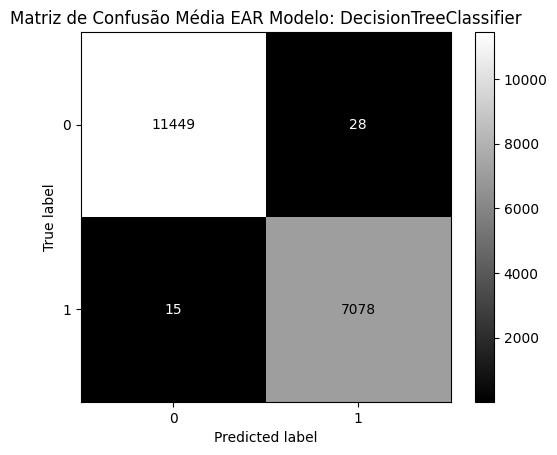

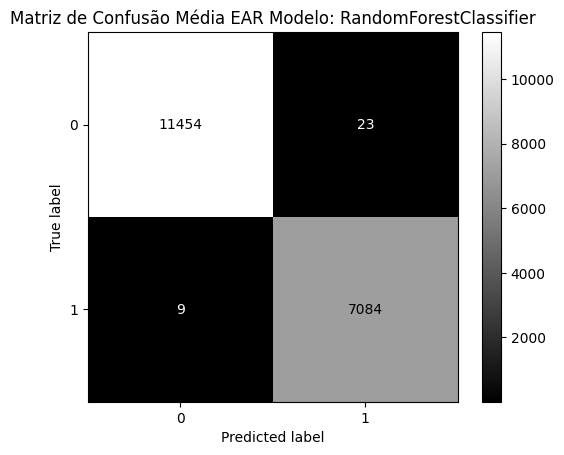

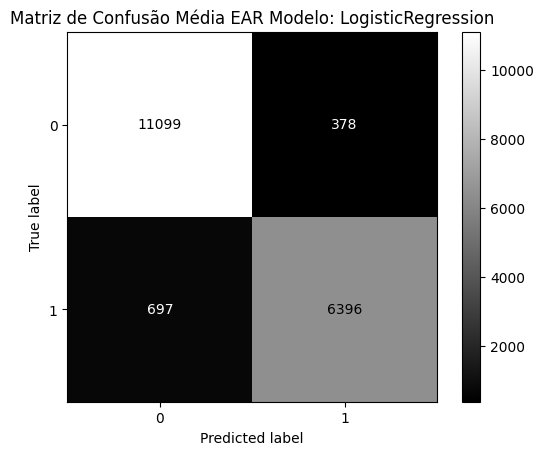

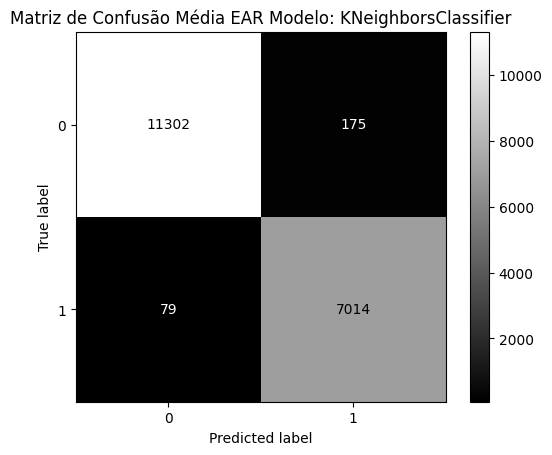

In [44]:
## SOMENTE EAR

for model in models:
    cm_total = np.zeros((2,2))
    for idx, df_test in enumerate(dfs):
        df_train = pd.concat([df for j, df in enumerate(dfs) if j != idx], ignore_index=True)

        X_train = df_train[["ear1","ear2","ear3","ear4","ear5"]]
        y_train = df_train["piscando"]

        X_test = df_test[["ear1","ear2","ear3","ear4","ear5"]]
        y_test = df_test["piscando"]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        cm_total += cm
    
    print(calculate_metrics_from_cm(cm_total))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_total, display_labels=[0,1])
    disp.plot(values_format=".0f", cmap="gray")
    plt.title("Matriz de Confusão Média EAR Modelo: " + model.__class__.__name__)

    caminho_para_salvar = f"../../imagensArtigo/matrizesEAR/{model.__class__.__name__}_cm_ear.png"
    plt.savefig(caminho_para_salvar, dpi=300, bbox_inches='tight') # dpi=300 para alta qualidade


{'Acurácia': np.float64(0.992), 'Precisão': np.float64(0.982), 'Revocação': np.float64(0.998), 'F1-Score': np.float64(0.99)}
{'Acurácia': np.float64(0.997), 'Precisão': np.float64(0.993), 'Revocação': np.float64(0.999), 'F1-Score': np.float64(0.996)}
{'Acurácia': np.float64(0.966), 'Precisão': np.float64(0.941), 'Revocação': np.float64(0.972), 'F1-Score': np.float64(0.956)}
{'Acurácia': np.float64(0.985), 'Precisão': np.float64(0.967), 'Revocação': np.float64(0.993), 'F1-Score': np.float64(0.98)}


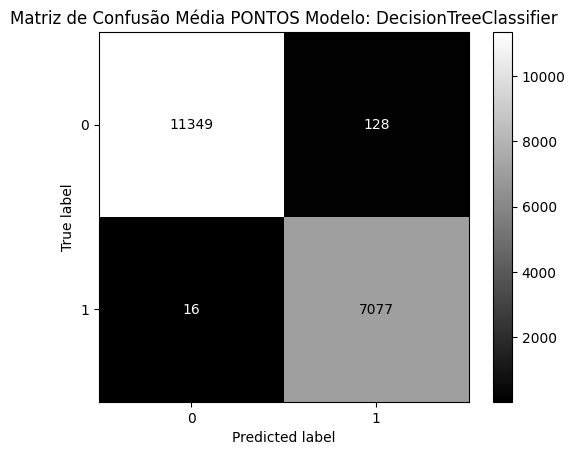

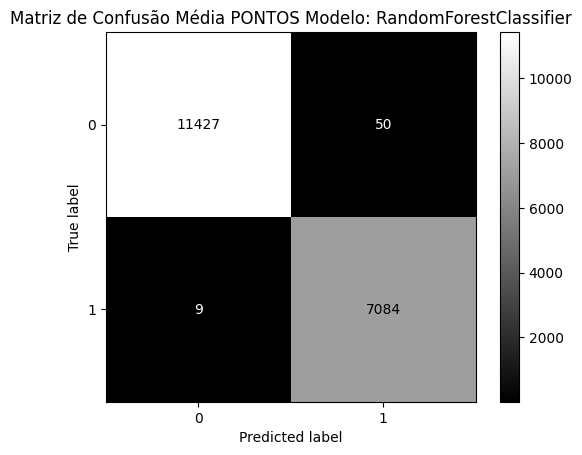

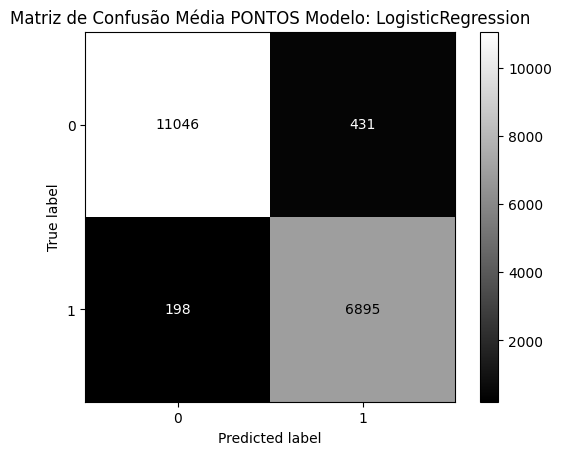

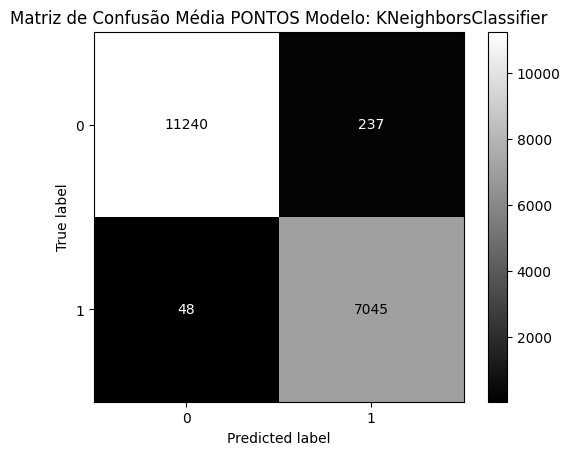

In [45]:
## SOMENTE PONTOS

feature_cols = []
for col in pontos_cols:
    feature_cols += [f"{col}_x{j}" for j in range(19)] + [f"{col}_y{j}" for j in range(19)]

for model in models:
    cm_total = np.zeros((2,2))
    for idx, df_test in enumerate(dfs):
        df_train = pd.concat([df for j, df in enumerate(dfs) if j != idx], ignore_index=True)
        
        X_train = df_train[feature_cols]
        y_train = df_train["piscando"]
        
        X_test = df_test[feature_cols]
        y_test = df_test["piscando"]
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        cm = confusion_matrix(y_test, y_pred)
        cm_total += cm
    print(calculate_metrics_from_cm(cm_total))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_total, display_labels=[0,1])
    disp.plot(values_format=".0f", cmap="gray")
    plt.title("Matriz de Confusão Média PONTOS Modelo: " + model.__class__.__name__)
    
    caminho_para_salvar = f"../../imagensArtigo/matrizesPONTOS/{model.__class__.__name__}_cm_pontos.png"
    plt.savefig(caminho_para_salvar, dpi=300, bbox_inches='tight') # dpi=300 para alta qualidade


In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

# Supondo que 'dfs' é a sua lista de DataFrames
# e a função calculate_metrics_from_cm já existe.

# --- INÍCIO DO CÓDIGO CORRIGIDO ---

## PROCURANDO MELHOR LIMIAR GERAL

# 1. Juntar todos os dataframes em um só
dfs_combined = pd.concat(dfs, ignore_index=True)

X_geral = dfs_combined[["ear1","ear2","ear3","ear4","ear5"]]
y_geral = dfs_combined["piscando"].astype(int)

# Pré-calcular a média das linhas para otimizar o processo
X_mean_geral = X_geral.mean(axis=1)

# 2. Função de avaliação (agora recebe os dados como parâmetros)
#    A lógica de predição (>) está mantida conforme sua necessidade.
def evaluate_threshold_geral(threshold, y_true, X_mean):
    y_pred = (X_mean > threshold).astype(int) # Sua lógica: EAR > threshold -> piscou
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    return acc, cm

# 3. Implementação da Busca em Grade (Grid Search)
best_acc = -1
best_thr = None
best_cm = None

# Define o espaço de busca. Geramos 500 candidatos a limiar
# no intervalo entre o menor e o maior valor médio de EAR observado.
threshold_candidates = np.linspace(X_mean_geral.min(), X_mean_geral.max(), 500)

print(f"Iniciando busca em grade com {len(threshold_candidates)} candidatos a limiar...")

# Itera sobre CADA candidato para garantir que o melhor seja encontrado
for thr_candidate in threshold_candidates:
    acc, cm = evaluate_threshold_geral(thr_candidate, y_geral, X_mean_geral)
    
    # Se a acurácia do candidato atual for a melhor encontrada, armazena seus dados
    if acc > best_acc:
        best_acc = acc
        best_thr = thr_candidate
        best_cm = cm

print("\n--- Resultado da Busca em Grade ---")
print(f"Melhor limiar geral encontrado: {best_thr:.4f}")
print(f"Acurácia correspondente: {best_acc:.4f}")
print("Matriz de confusão:\n", best_cm)

Iniciando busca em grade com 500 candidatos a limiar...

--- Resultado da Busca em Grade ---
Melhor limiar geral encontrado: 7.1157
Acurácia correspondente: 0.9370
Matriz de confusão:
 [[10807   670]
 [  499  6594]]


In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

# Função para calcular métricas (você já a tem)
def calculate_metrics_from_cm(cm, precision_digits=3):
    TN, FP, FN, TP = cm.ravel()
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0.0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    return {
        "Acurácia": round(accuracy, precision_digits), "Precisão": round(precision, precision_digits),
        "Revocação": round(recall, precision_digits), "F1-Score": round(f1_score, precision_digits),
    }


def evaluate_threshold(threshold, y_true, X_mean):
    y_pred = (X_mean > threshold).astype(int) 
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    return acc, cm

# Supondo que 'dfs' é sua lista de dataframes
for idx, df_test in enumerate(dfs):
    X = df_test[["ear1", "ear2", "ear3", "ear4", "ear5"]]
    y = df_test["piscando"].astype(int)

    # Pré-calcule a média para otimização
    X_mean = X.mean(axis=1)

    # 2. IMPLEMENTAÇÃO DA BUSCA EM GRADE (GRID SEARCH)
    
    # Define o espaço de busca para os limiares. 500 passos é um bom número.
    # Usamos os valores min/max da média de EAR como limites do intervalo.
    threshold_candidates = np.linspace(X_mean.min(), X_mean.max(), 500)
    
    best_acc = -1
    best_thr = None
    best_cm = None

    # Itera sobre cada candidato a limiar
    for thr_candidate in threshold_candidates:
        acc, cm = evaluate_threshold(thr_candidate, y, X_mean)
        
        # Se a acurácia deste candidato for a melhor até agora, guarde os resultados
        if acc > best_acc:
            best_acc = acc
            best_thr = thr_candidate
            best_cm = cm

    print(f"Melhor limiar para {idx + 1}: {best_thr:.4f}")
    print(calculate_metrics_from_cm(best_cm))

    # Avalia com o limiar fixo para comparação
    fixo_acc, fixo_cm = evaluate_threshold(7.1157, y, X_mean)

    print(f"Com limiar fixo para {idx + 1}: 7.1157")
    print(calculate_metrics_from_cm(fixo_cm))
    print("-" * 30)

Melhor limiar para 1: 16.4911
{'Acurácia': np.float64(0.983), 'Precisão': np.float64(0.984), 'Revocação': np.float64(0.978), 'F1-Score': np.float64(0.981)}
Com limiar fixo para 1: 7.1157
{'Acurácia': np.float64(0.961), 'Precisão': np.float64(0.927), 'Revocação': np.float64(0.995), 'F1-Score': np.float64(0.96)}
------------------------------
Melhor limiar para 2: 7.1016
{'Acurácia': np.float64(0.924), 'Precisão': np.float64(0.908), 'Revocação': np.float64(0.919), 'F1-Score': np.float64(0.914)}
Com limiar fixo para 2: 7.1157
{'Acurácia': np.float64(0.924), 'Precisão': np.float64(0.91), 'Revocação': np.float64(0.917), 'F1-Score': np.float64(0.914)}
------------------------------
Melhor limiar para 3: 7.1016
{'Acurácia': np.float64(0.941), 'Precisão': np.float64(0.914), 'Revocação': np.float64(0.932), 'F1-Score': np.float64(0.923)}
Com limiar fixo para 3: 7.1157
{'Acurácia': np.float64(0.941), 'Precisão': np.float64(0.914), 'Revocação': np.float64(0.931), 'F1-Score': np.float64(0.923)}
---

In [16]:
cm_total = np.zeros((2,2))

dfs_combined = pd.concat(dfs, ignore_index=True)

X = df_bruno[["ear1","ear2","ear3","ear4","ear5"]]
y = df_bruno["piscando"]

total = 7.1157

y_pred = (X.mean(axis=1) > total).astype(float)

print(accuracy_score(y, y_pred))

cm = confusion_matrix(y, y_pred)
cm_total += cm


0.9613466334164589


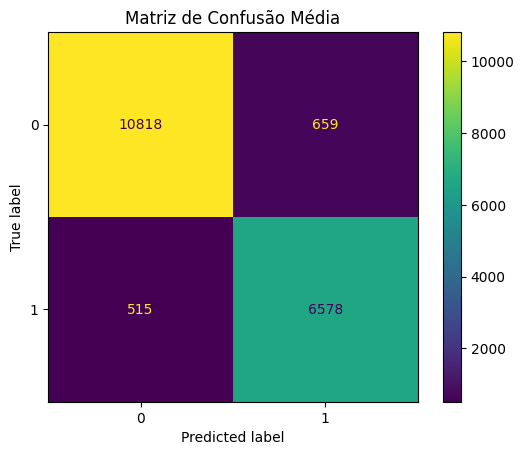

In [10]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_total, display_labels=[0,1])
disp.plot()
plt.title("Matriz de Confusão Média")
plt.show()

In [6]:
def calculate_metrics_from_cm(cm, precision_digits=3):

    TN, FP, FN, TP = cm.ravel()

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    metrics = {
        "Acurácia": round(accuracy, precision_digits),
        "Precisão": round(precision, precision_digits),
        "Revocação": round(recall, precision_digits),
        "F1-Score": round(f1_score, precision_digits),
    }
    
    return metrics


/tmp/ipykernel_8429/1348197033.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=usuarios, y=limiares, palette='gray')


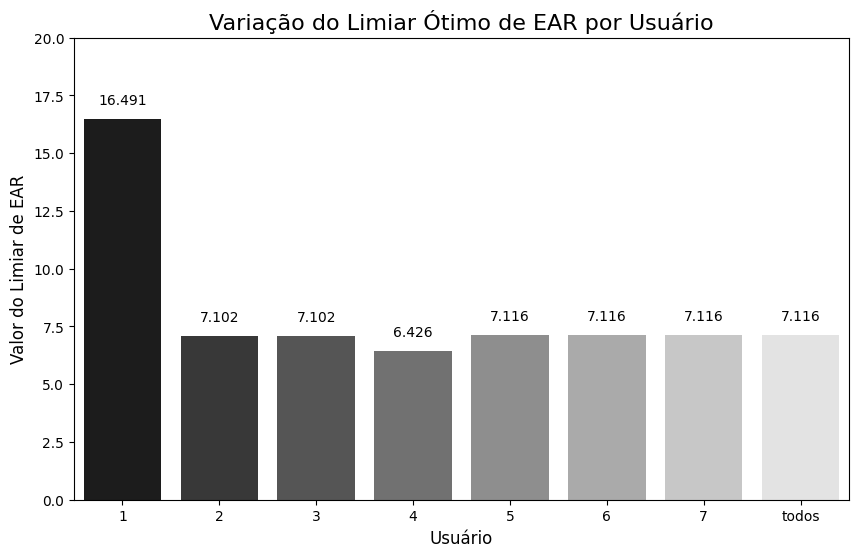

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dados dos limiares individuais
dados_limiar = {
    '1': 16.4911,
    '2': 7.1016,
    '3': 7.1016,
    '4': 6.4261,
    '5': 7.1157,
    '6': 7.1157,
    '7': 7.1157,
    'todos': 7.1157  # Este é o novo "limiar fixo" usado para a comparação de todos
}

usuarios = list(dados_limiar.keys())
limiares = list(dados_limiar.values())

plt.figure(figsize=(10, 6))
sns.barplot(x=usuarios, y=limiares, palette='gray')
plt.title('Variação do Limiar Ótimo de EAR por Usuário', fontsize=16)
plt.ylabel('Valor do Limiar de EAR', fontsize=12)
plt.xlabel('Usuário', fontsize=12)
plt.ylim(0, 20) # Ajuste o limite para melhor visualização
for index, value in enumerate(limiares):
    plt.text(index, value + 0.5, f'{value:.3f}', ha='center', va='bottom')

# Salvar a figura para usar no artigo
plt.savefig('../../imagensArtigo/variacao_limiar.png', dpi=300, bbox_inches='tight')
plt.show()
